# Comparison Study of Outlier Detection
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lscp

https://pypi.org/project/pyod/

ref로 좋을것 같은?
https://arxiv.org/pdf/1809.10816.pdf

|Method|Category|JIT Enabled|Multicore|cited|
|:--|:--:|:--:|:--:|:--:|
|LOF (Breunig et al., 2000)|Proximity|No|Yes||
|kNN (Ramaswamy et al., 2000)|Proximity|No|Yes||
|AvgkNN (Angiulli and Pizzuti, 2002)|Proximity|No|Yes||
|CBLOF (He et al., 2003)|Proximity|Yes|No||
|OCSVM (Sch ̈olkopf et al., 2001)|Linear Model|No|No||
|LOCI (Papadimitriou et al., 2003)|Proximity|Yes|No|1157|
|PCA (Shyu et al., 2003)|Linear Model|No|No||
|MCD (Hardin and Rocke, 2004)|Linear Model|No|No||
|Feature Bagging (Lazarevic and Kumar, 2005)|Ensembling|No|Yes||
|ABOD (Kriegel et al., 2008)|Proximity|Yes|No|884|
|Isolation Forest (Liu et al., 2008)|Ensembling|No|Yes||
|HBOS (Goldstein and Dengel, 2012)|Proximity|Yes|No||
|SOS (Janssens et al., 2012)|Proximity|Yes|No||
|AutoEncoder (Sakurada and Yairi, 2014)|Neural Net|Yes|No||
|AOM (Aggarwal and Sathe, 2015)|Ensembling|No|No||
|MOA (Aggarwal and Sathe, 2015)|Ensembling|No|No||
|SO-GAAL (Liu et al., 2019)|Neural Net|No|No||
|MO-GAAL (Liu et al., 2019)|Neural Net|No|No||
|XGBOD (Zhao and Hryniewicki, 2018b)|Ensembling|No|Yes|93|
|LSCP (Zhao et al., 2019)|Ensembling|No|No|97|

**Linear**

```python
signal = sample(c(runif(25,-7,-2.5), runif(25,2.5,7), rep(0,950)))
```

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.970**|**0.969**|**1.000**|**0.984**|
|LOF (Breunig et al., 2000)|0.879|0.969|0.901|0.934|
|OCSVM (Sch¨olkopf et al., 2001)|0.938|0.992|0.942|0.967|
|ABOD (Kriegel et al., 2008)|0.976|0.987|0.987|0.987|
|Isolation Forest (Liu et al., 2008)|0.864|0.998|0.859|0.923|
|LOCI (Papadimitriou et al., 2003)|0.957|0.986|0.968|0.977|
|HBOS (Goldstein and Dengel, 2012)|0.960|0.978|0.980|0.979|
|SO-GAAL (Liu et al., 2019)|0.897|0.969|0.921|0.944|
|MCD (Hardin and Rocke, 2004)|0.950|1.000|0.947|0.973|
|MO-GAAL (Liu et al., 2019)|0.897|0.969|0.921|0.944|

**one dimensional manifold**

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.997**|**0.997**|**1.000**|**0.998**|
|LOF (Breunig et al., 2000)|0.886|0.987|0.892|0.937|
|OCSVM (Sch¨olkopf et al., 2001)|0.923|0.988|0.931|0.958|
|ABOD (Kriegel et al., 2008)|0.988|0.994|0.994|0.994|
|Isolation Forest (Liu et al., 2008)|0.477|0.989|0.455|0.623|
|LOCI (Papadimitriou et al., 2003)|0.967|0.975|0.991|0.983|
|HBOS (Goldstein and Dengel, 2012)|0.881|0.961|0.912|0.936|
|SO-GAAL (Liu et al., 2019)|0.950|0.950|1.000|0.974|
|MCD (Hardin and Rocke, 2004)|0.866|0.953|0.903|0.928|
|MO-GAAL (Liu et al., 2019)|0.879|0.958|0.913|0.935|

Bunny

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.991**|**0.993**|**0.997**|**0.995**|
|LOF (Breunig et al., 2000)|0.918|0.954|0.959|0.957|
|OCSVM (Sch¨olkopf et al., 2001)|0.865|0.955|0.901|0.927|
|ABOD (Kriegel et al., 2008)|0.905|0.951|0.949|0.950|
|Isolation Forest (Liu et al., 2008)|0.761|0.953|0.789|0.863|
|LOCI (Papadimitriou et al., 2003)||||
|HBOS (Goldstein and Dengel, 2012)|0.895|0.970|0.919|0.944|
|SO-GAAL (Liu et al., 2019)|0.952|0.952|1.000|0.975|
|MCD (Hardin and Rocke, 2004)|0.934|0.992|0.938|0.964|
|MO-GAAL (Liu et al., 2019)||||

ref: https://scikit-learn.org/stable/modules/outlier_detection.html

https://conferenceindex.org/conferences/applied-statistics

**Inliers are labeled 1, while outliers are labeled -1**

In [3026]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest
# from pyod.models.iforest import IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

from PyNomaly import loop

from sklearn import svm

from loci.loci import run_loci

from pyod.models.lscp import LSCP
from pyod.models.hbos import HBOS

from pyod.models.so_gaal import SO_GAAL
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL


## EbayesThresh

In [2863]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


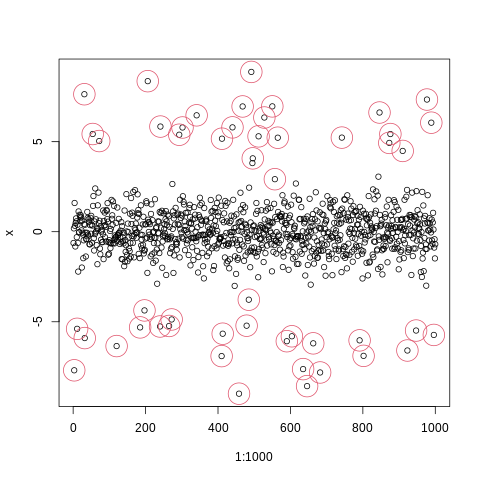

In [2864]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [2865]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [2866]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [2867]:
xhat = np.array(ebayesthresh(FloatVector(x)))

In [2868]:
# plt.plot(x)
# plt.plot(xhat)

In [2869]:
outlier_true_index = index_of_trueoutlier

In [2870]:
outlier_true_value = x[index_of_trueoutlier]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [2871]:
outlier_true_one = signal.copy()

In [2872]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## Linear

In [3027]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [3028]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [3029]:
X = np.array(_df)

### 1. Proposed Method

In [2486]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [2487]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [2488]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [2489]:
w=np.zeros((1000,1000))

In [2490]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [2491]:
_simul = SIMUL(_df)

In [2492]:
_simul.fit(sd=20)

In [2493]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>25').reset_index()['index'])

In [2494]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>25').reset_index()['y'])

In [2495]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [2496]:
outlier_simul_one = list(map(lambda x: -1 if x > 25 else 1,outlier_simul_one))

In [2497]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

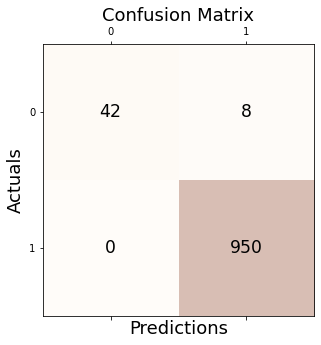

In [2498]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2499]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.992
Precision: 0.992
Recall: 1.000
F1 Score: 0.996


### 2. LOF

In [2500]:
clf = LocalOutlierFactor(n_neighbors=2)

In [2501]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

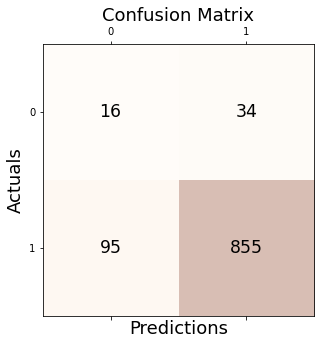

In [2502]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2503]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.871
Precision: 0.962
Recall: 0.900
F1 Score: 0.930


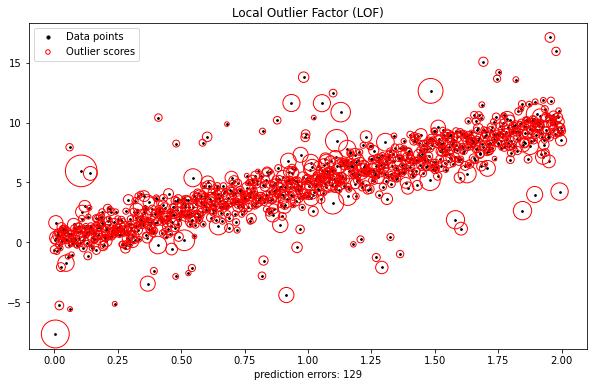

In [2504]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

### 3. SVM

In [2505]:
X = np.array(_df).reshape(-1,2)

In [2506]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [2507]:
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [2508]:
y_pred = clf.predict(X)

In [2509]:
outlier_OSVM_one = list(clf.predict(X))

In [2510]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

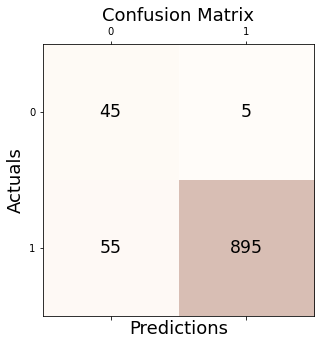

In [2511]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2512]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.940
Precision: 0.994
Recall: 0.942
F1 Score: 0.968


### 4. ABOD

In [2513]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [2514]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

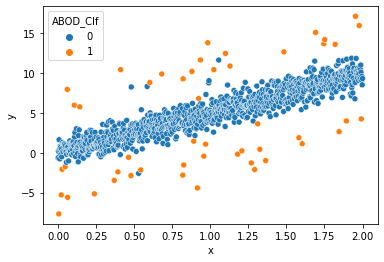

In [2515]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [2516]:
outlier_ABOD_one = list(abod_clf.labels_)

In [2517]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [2518]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

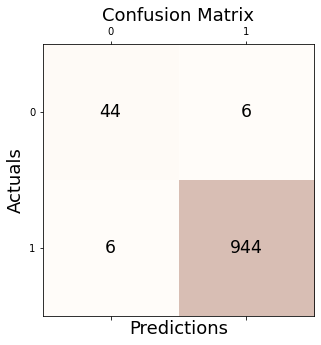

In [2519]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2520]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994


### 5. IForest

In [2521]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [2522]:
od.fit(_df[['x', 'y']])

In [2523]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

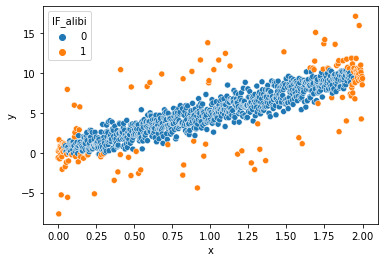

In [2524]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [2525]:
outlier_alibi_one = _df['IF_alibi']

In [2526]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [2527]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

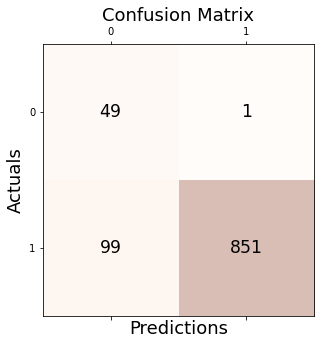

In [2528]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2529]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.900
Precision: 0.999
Recall: 0.896
F1 Score: 0.945


### 6. LOCI

In [2638]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [2639]:
X = np.array(_df).reshape(-1,2)

In [2554]:
loci_res = run_loci(_df)

In [2569]:
outlier_indices = loci_res.outlier_indices

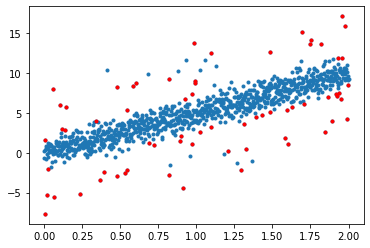

In [2570]:
plt.plot(_df['x'], _df['y'],'.')
plt.plot(X[outlier_indices, 0],X[outlier_indices, 1],'r.')

In [2664]:
loci = list(outlier_indices)

In [2665]:
outlier_loci_one = list(range(0,1000))

In [2666]:
for i in range(0,1000):
    if outlier_loci_one[i] in loci:
        outlier_loci_one[i] = -1
    else:
        outlier_loci_one[i] = 1

In [2667]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_loci_one)

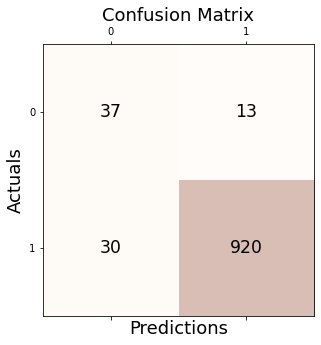

In [2668]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2670]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_loci_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_loci_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_loci_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_loci_one))

Accuracy: 0.957
Precision: 0.986
Recall: 0.968
F1 Score: 0.977


### 7. HBOS

In [2813]:
HBOS_clf = HBOS()
HBOS_clf.fit(_df[['x', 'y']])

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [2814]:
_df['HBOS_clf'] = HBOS_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

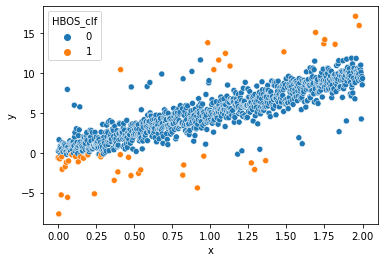

In [2815]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'HBOS_clf')

In [2816]:
outlier_HBOS_one = list(HBOS_clf.labels_)

In [2817]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [2818]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_HBOS_one)

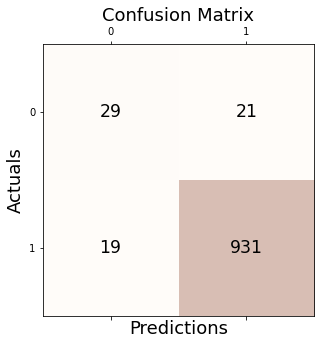

In [2819]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2820]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_HBOS_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_HBOS_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_HBOS_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_HBOS_one))

Accuracy: 0.960
Precision: 0.978
Recall: 0.980
F1 Score: 0.979


### 8. SO_GAAL

In [2953]:
SO_GAAL_clf = SO_GAAL()
SO_GAAL_clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

SO_GAAL(contamination=0.1, decay=1e-06, lr_d=0.01, lr_g=0.0001, momentum=0.9,
    stop_epochs=20)

In [2954]:
_df['SO_GAAL_clf'] = SO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

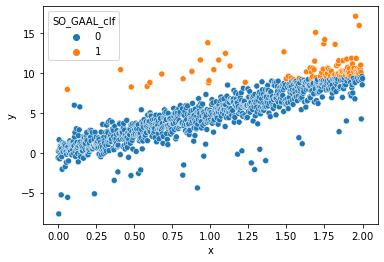

In [2955]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'SO_GAAL_clf')

In [2956]:
outlier_SO_GAAL_clf_one = list(SO_GAAL_clf.labels_)

In [2957]:
outlier_SO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_clf_one))

In [2958]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_SO_GAAL_clf_one)

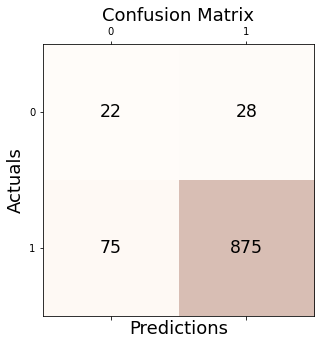

In [2959]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2960]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_SO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_SO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_SO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_SO_GAAL_clf_one))

Accuracy: 0.897
Precision: 0.969
Recall: 0.921
F1 Score: 0.944


### 9. MCD

In [2961]:
MCD_clf = MCD()
MCD_clf.fit(_df[['x', 'y']])

MCD(assume_centered=False, contamination=0.1, random_state=None,
  store_precision=True, support_fraction=None)

In [2962]:
_df['MCD_clf'] = MCD_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

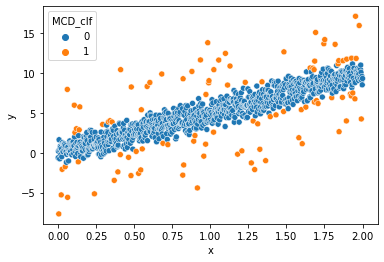

In [2963]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MCD_clf')

In [2968]:
outlier_MCD_one = list(MCD_clf.labels_)

In [2969]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [2970]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_MCD_one)

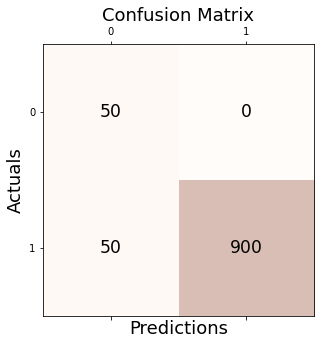

In [2971]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2972]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_MCD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_MCD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_MCD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_MCD_one))

Accuracy: 0.950
Precision: 1.000
Recall: 0.947
F1 Score: 0.973


### 10. MO_GAAL

In [3030]:
MO_GAAL_clf = MO_GAAL()
MO_GAAL_clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

MO_GAAL(contamination=0.1, decay=1e-06, k=10, lr_d=0.01, lr_g=0.0001,
    momentum=0.9, stop_epochs=20)

In [3031]:
_df['MO_GAAL_clf'] = MO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

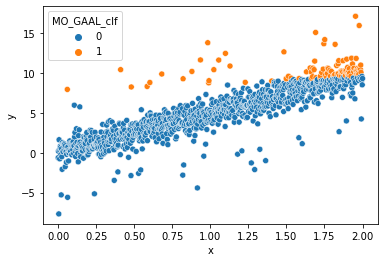

In [3032]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MO_GAAL_clf')

In [3033]:
outlier_MO_GAAL_clf_one = list(MO_GAAL_clf.labels_)

In [3034]:
outlier_MO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_clf_one))

In [3035]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_MO_GAAL_clf_one)

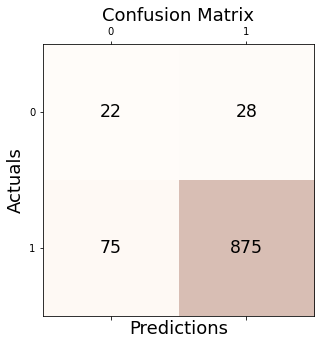

In [3036]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [3037]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_MO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_MO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_MO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_MO_GAAL_clf_one))

Accuracy: 0.897
Precision: 0.969
Recall: 0.921
F1 Score: 0.944


## Orbit

In [3038]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [3039]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

### 1. Proposed Method

In [2674]:
X = np.array(_df)

In [2675]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [2676]:
_simul = SIMUL(_df)

In [2677]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 517.55it/s]


In [2678]:
_simul.get_weightmatrix(theta=(_simul.D[_simul.D>0].mean()),kappa=2500) 

In [2679]:
_simul.fit(sd=15,ref=20)

In [2680]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>20').reset_index()['index'])

In [2681]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>20').reset_index()['y'])

In [2682]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [2683]:
outlier_simul_one = list(map(lambda x: -1 if x > 20 else 1,outlier_simul_one))

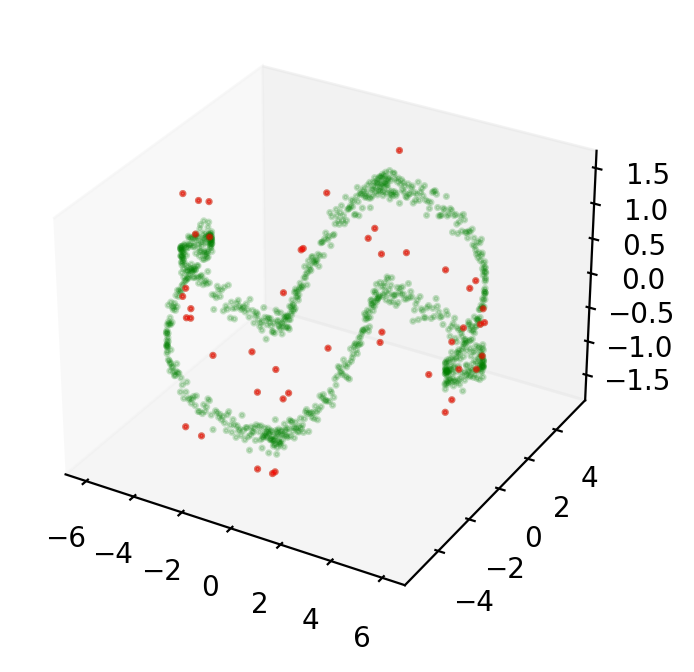

In [2684]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_simul.df.loc[outlier_simul_first_index]['x'],_simul.df.loc[outlier_simul_first_index]['y'],_simul.df.loc[outlier_simul_first_index]['f'], zdir='z',s=10,marker='.',c='red',alpha=0.5)
# ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

In [2685]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

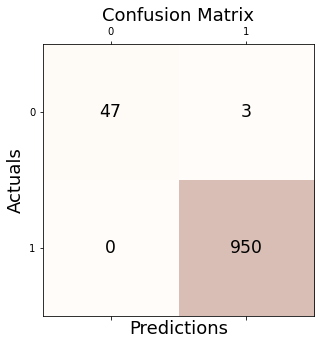

In [2686]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2687]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.997
Precision: 0.997
Recall: 1.000
F1 Score: 0.998


### 2. LOF

In [2688]:
clf = LocalOutlierFactor(n_neighbors=2)

<Figure size 720x432 with 0 Axes>

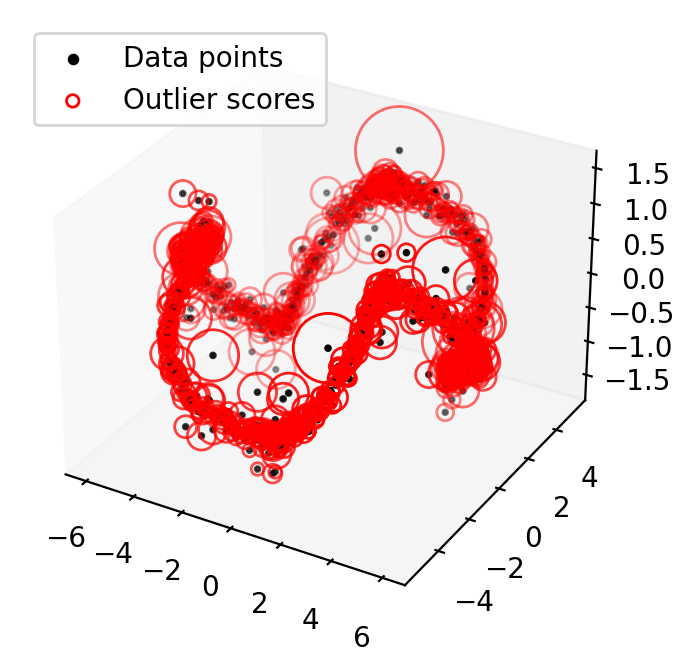

In [2689]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
# ax.title("Local Outlier Factor (LOF)")
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
ax.scatter3D(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
ax.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# ax.xlabel("prediction errors: %d" % (n_errors))
legend = ax.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
# ax.show()

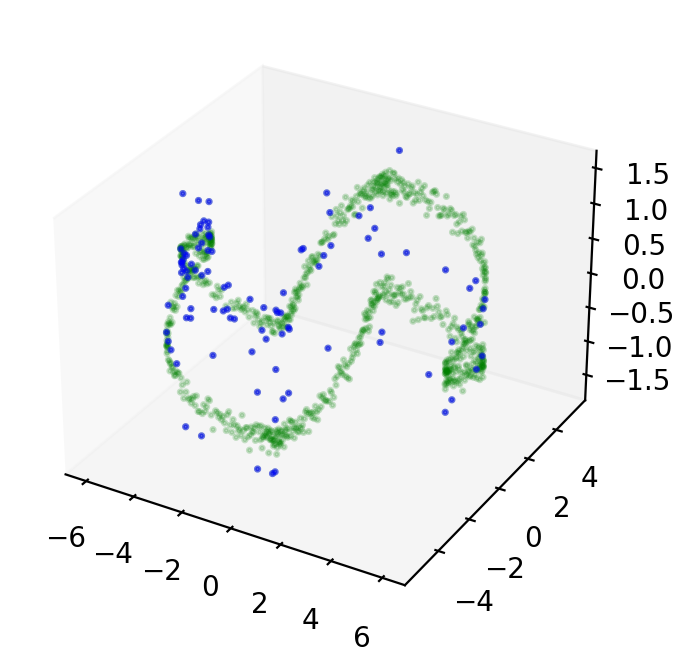

In [2690]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_df.loc[outlier_first_index]['x'],_df.loc[outlier_first_index]['y'],_df.loc[outlier_first_index]['f'], zdir='z',s=10,marker='.',c='blue',alpha=0.5)
# ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

outlier

In [2691]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [2692]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [2693]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

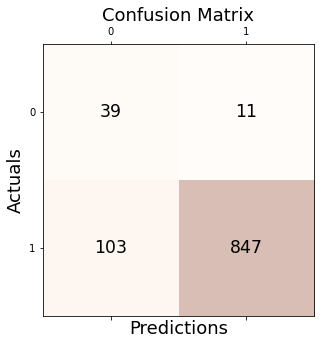

In [2694]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2695]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.886
Precision: 0.987
Recall: 0.892
F1 Score: 0.937


### 3. SVM

In [2696]:
X = np.array(_df).reshape(-1,3)

In [2697]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [2698]:
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [2699]:
y_pred = clf.predict(X)

In [2700]:
outlier_OSVM_one = list(clf.predict(X))

In [2701]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

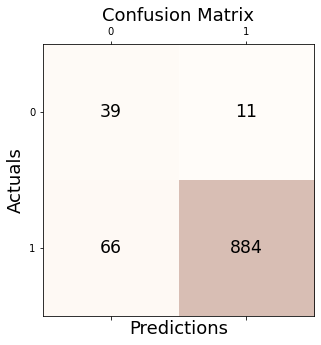

In [2702]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2703]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.923
Precision: 0.988
Recall: 0.931
F1 Score: 0.958


### 4. ABOD

In [2704]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y','f']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [2705]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y', 'f']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

In [2706]:
outlier_ABOD_one = list(abod_clf.labels_)

In [2707]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [2708]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

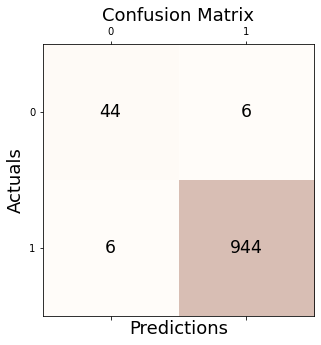

In [2709]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2710]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994


### 5. IForest

In [2711]:
od.fit(_df[['x', 'y','f']])

In [2712]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

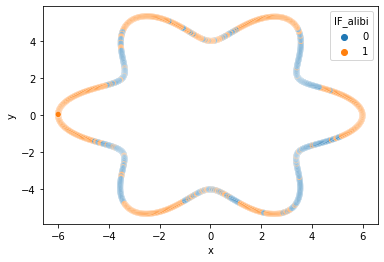

In [2713]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [2714]:
outlier_alibi_one = _df['IF_alibi']

In [2715]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [2716]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

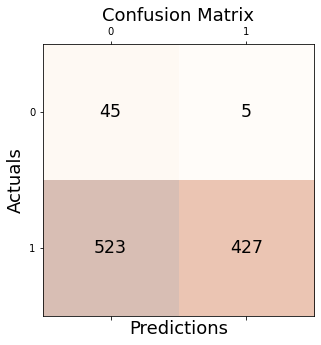

In [2717]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2718]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.472
Precision: 0.988
Recall: 0.449
F1 Score: 0.618


### 6. LOCI

In [2744]:
X = np.array(_df).reshape(-1,3)

In [2745]:
loci_res = run_loci(X)

In [2746]:
outlier_indices = loci_res.outlier_indices

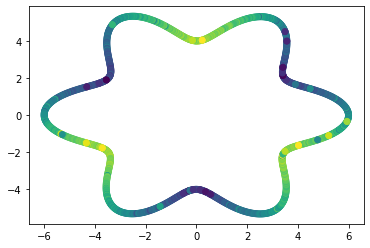

In [2747]:
plt.scatter(_df['x'], _df['y'],c=_df['f'])
plt.scatter(X[outlier_indices, 0],X[outlier_indices, 1],c=X[outlier_indices, 2])

In [2748]:
loci = list(outlier_indices)

In [2749]:
outlier_loci_one = list(range(0,1000))

In [2750]:
for i in range(0,1000):
    if outlier_loci_one[i] in loci:
        outlier_loci_one[i] = -1
    else:
        outlier_loci_one[i] = 1

In [2751]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_loci_one)

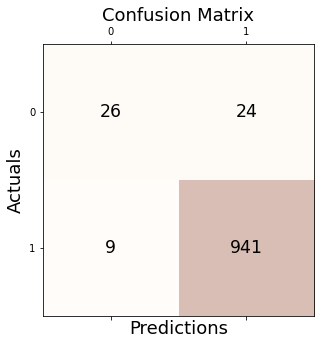

In [2752]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2753]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_loci_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_loci_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_loci_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_loci_one))

Accuracy: 0.967
Precision: 0.975
Recall: 0.991
F1 Score: 0.983


### 7. HBOS

In [2905]:
HBOS_clf = HBOS()
HBOS_clf.fit(_df[['x', 'y','f']])

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [2906]:
_df['HBOS_clf'] = HBOS_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

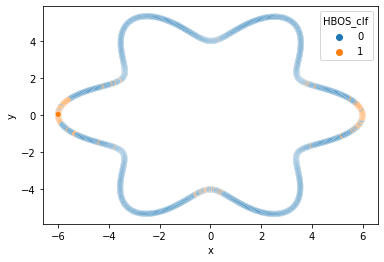

In [2907]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'HBOS_clf')

In [2908]:
outlier_HBOS_one = list(HBOS_clf.labels_)

In [2909]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [2910]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_HBOS_one)

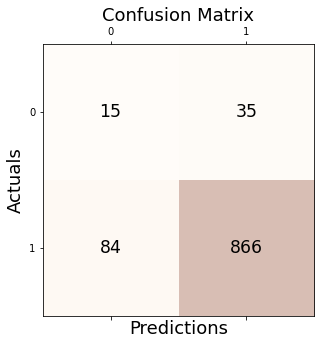

In [2911]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2912]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_HBOS_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_HBOS_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_HBOS_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_HBOS_one))

Accuracy: 0.881
Precision: 0.961
Recall: 0.912
F1 Score: 0.936


### 8. SO_GAAL

In [2975]:
SO_GAAL_clf = SO_GAAL()
SO_GAAL_clf.fit(_df[['x', 'y','f']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

SO_GAAL(contamination=0.1, decay=1e-06, lr_d=0.01, lr_g=0.0001, momentum=0.9,
    stop_epochs=20)

In [2976]:
_df['SO_GAAL_clf'] = SO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

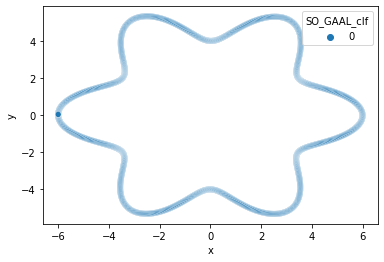

In [2977]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'SO_GAAL_clf')

In [2978]:
outlier_SO_GAAL_clf_one = list(SO_GAAL_clf.labels_)

In [2979]:
outlier_SO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_clf_one))

In [2980]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_SO_GAAL_clf_one)

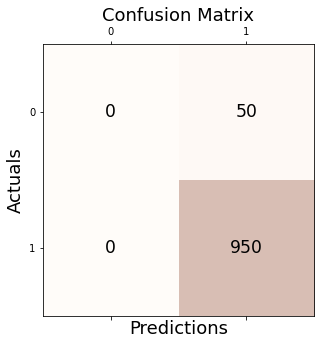

In [2981]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2982]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_SO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_SO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_SO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_SO_GAAL_clf_one))

Accuracy: 0.950
Precision: 0.950
Recall: 1.000
F1 Score: 0.974


### 9. MCD

In [2983]:
MCD_clf = MCD()
MCD_clf.fit(_df[['x', 'y','f']])

MCD(assume_centered=False, contamination=0.1, random_state=None,
  store_precision=True, support_fraction=None)

In [2984]:
_df['MCD_clf'] = MCD_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

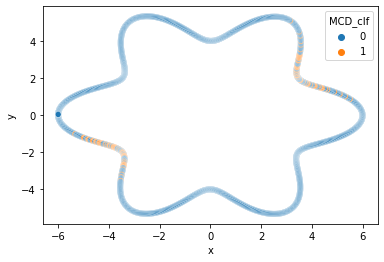

In [2985]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MCD_clf')

In [2986]:
outlier_MCD_one = list(MCD_clf.labels_)

In [2987]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [2988]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_MCD_one)

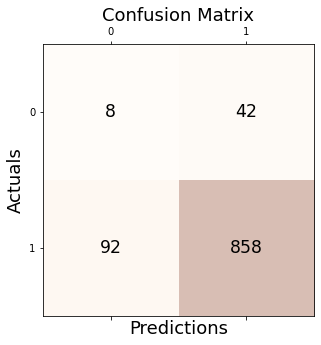

In [2989]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2990]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_MCD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_MCD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_MCD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_MCD_one))

Accuracy: 0.866
Precision: 0.953
Recall: 0.903
F1 Score: 0.928


### 10. MO_GAAL

In [3040]:
MO_GAAL_clf = MO_GAAL()
MO_GAAL_clf.fit(_df[['x', 'y','f']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

MO_GAAL(contamination=0.1, decay=1e-06, k=10, lr_d=0.01, lr_g=0.0001,
    momentum=0.9, stop_epochs=20)

In [3041]:
_df['MO_GAAL_clf'] = MO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

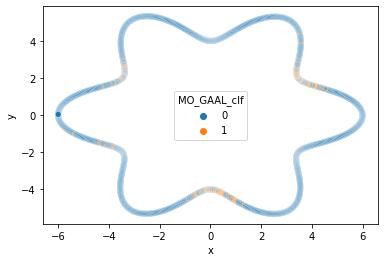

In [3042]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MO_GAAL_clf')

In [3043]:
outlier_MO_GAAL_clf_one = list(MO_GAAL_clf.labels_)

In [3044]:
outlier_MO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_clf_one))

In [3045]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_MO_GAAL_clf_one)

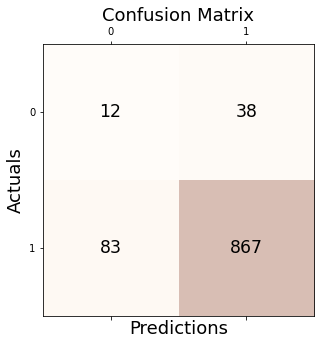

In [3046]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [3047]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_MO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_MO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_MO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_MO_GAAL_clf_one))

Accuracy: 0.879
Precision: 0.958
Recall: 0.913
F1 Score: 0.935


## Bunny

In [3048]:
G = graphs.Bunny()
n = G.N

In [3049]:
g = filters.Heat(G, tau=75) 

In [3050]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [3051]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-18 06:44:38,495:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [3052]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [3053]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [3054]:
outlier_true_index_2 = np.where(unif!=0)

In [3055]:
outlier_true_value_2 = unif[unif!=0]

In [3056]:
outlier_true_one_2 = unif.copy()

In [3057]:
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))

### 1. Proposed Method

In [2423]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [2424]:
_simul = SIMUL(_df)

In [2425]:
_simul.fit(sd=20,ref=10)

In [2426]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>10').reset_index()['index'])

In [2427]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>10').reset_index()['y'])

In [2428]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [2429]:
outlier_simul_one = list(map(lambda x: -1 if x > 10 else 1,outlier_simul_one))

In [2430]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_simul_one)

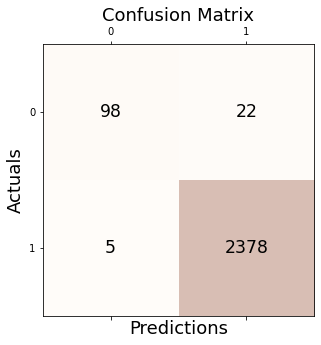

In [2431]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2432]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_simul_one))

Accuracy: 0.989
Precision: 0.991
Recall: 0.998
F1 Score: 0.994


### 2.LOF

In [2433]:
X = np.array(_df)

In [2434]:
clf = LocalOutlierFactor(n_neighbors=2)

In [2435]:
clf.fit_predict(X[:,:4])

array([1, 1, 1, ..., 1, 1, 1])

outlier

In [2436]:
outlier_first_index = np.where(clf.fit_predict(X[:,:4])==-1)

In [2437]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X[:,:4])==-1]

In [2438]:
conf_matrix = confusion_matrix(outlier_true_one_2, clf.fit_predict(X[:,:4]))

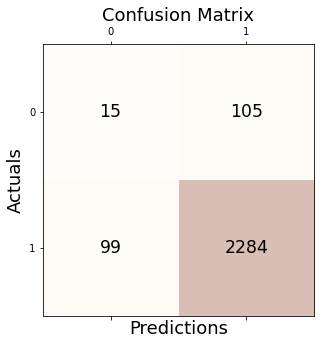

In [2439]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2440]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Precision: %.3f' % precision_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Recall: %.3f' % recall_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))

Accuracy: 0.918
Precision: 0.956
Recall: 0.958
F1 Score: 0.957


### 3.SVM

In [2441]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise})

In [2442]:
_df = np.array(_df).reshape(-1,4)

In [2443]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [2444]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [2445]:
y_pred = clf.predict(_df)

In [2446]:
outlier_OSVM_one = list(clf.predict(_df))

In [2447]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_OSVM_one)

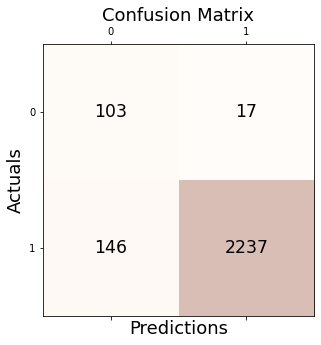

In [2448]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2449]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_OSVM_one))

Accuracy: 0.935
Precision: 0.992
Recall: 0.939
F1 Score: 0.965


### 4. ABOD

In [2450]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [2451]:
od.fit(_df[['x', 'y','z','fnoise']])

In [2452]:
preds = od.predict(
    _df[['x', 'y','z','fnoise']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

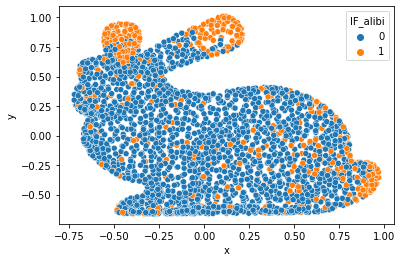

In [2453]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [2454]:
outlier_alibi_one = _df['IF_alibi']

In [2455]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [2456]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_alibi_one)

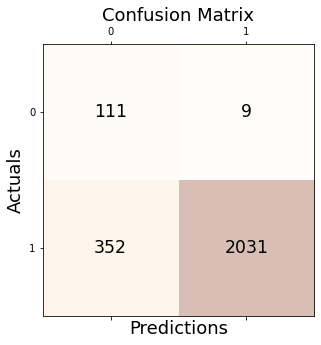

In [2457]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2458]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_alibi_one))

Accuracy: 0.856
Precision: 0.996
Recall: 0.852
F1 Score: 0.918


### 5. IForest

In [2459]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise})

In [2460]:
od.fit(_df[['x', 'y','z','fnoise']])

In [2462]:
preds = od.predict(
    _df[['x', 'y','z','fnoise']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

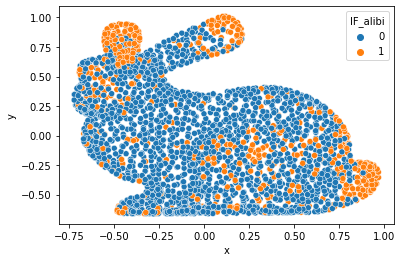

In [2463]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [2464]:
outlier_alibi_one = _df['IF_alibi']

In [2465]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [2467]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_alibi_one)

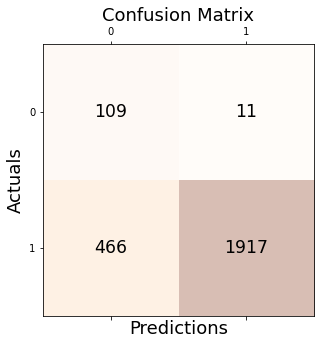

In [2468]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2469]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_alibi_one))

Accuracy: 0.809
Precision: 0.994
Recall: 0.804
F1 Score: 0.889


### 6. LOCI

In [2774]:
X = np.array(_df.iloc[:,0:4]).reshape(-1,4)

In [ ]:
loci_res = run_loci(X)

In [ ]:
outlier_indices = loci_res.outlier_indices

In [ ]:
plt.scatter(_df['x'], _df['y'],c=_df['fnoise'])
plt.scatter(X[outlier_indices, 0],X[outlier_indices, 1],c=X[outlier_indices, 3])

In [ ]:
loci = list(outlier_indices)

In [ ]:
outlier_loci_one = list(range(0,1000))

In [ ]:
for i in range(0,1000):
    if outlier_loci_one[i] in loci:
        outlier_loci_one[i] = -1
    else:
        outlier_loci_one[i] = 1

In [ ]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_loci_one)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_loci_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_loci_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_loci_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_loci_one))

### 7. HBOS

In [2933]:
HBOS_clf = HBOS()
HBOS_clf.fit(_df[['x', 'y','fnoise']])

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [2934]:
_df['HBOS_clf'] = HBOS_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

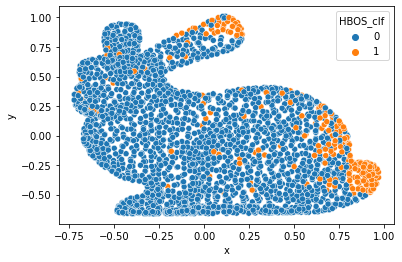

In [2935]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'HBOS_clf')

In [2936]:
outlier_HBOS_one = list(HBOS_clf.labels_)

In [2937]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [2938]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_HBOS_one)

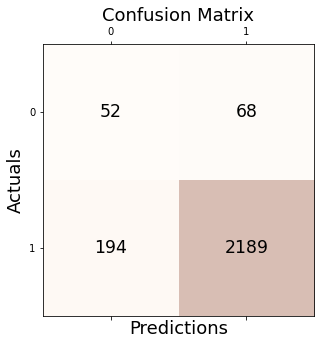

In [2939]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [2940]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_HBOS_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_HBOS_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_HBOS_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_HBOS_one))

Accuracy: 0.895
Precision: 0.970
Recall: 0.919
F1 Score: 0.944


### 8. SO_GAAL

In [3001]:
SO_GAAL_clf = SO_GAAL()
SO_GAAL_clf.fit(_df[['x', 'y','fnoise']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

SO_GAAL(contamination=0.1, decay=1e-06, lr_d=0.01, lr_g=0.0001, momentum=0.9,
    stop_epochs=20)

In [3005]:
_df['SO_GAAL_clf'] = SO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

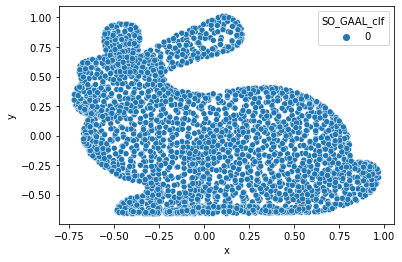

In [3006]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'SO_GAAL_clf')

In [3007]:
outlier_SO_GAAL_clf_one = list(SO_GAAL_clf.labels_)

In [3008]:
outlier_SO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_clf_one))

In [3009]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_SO_GAAL_clf_one)

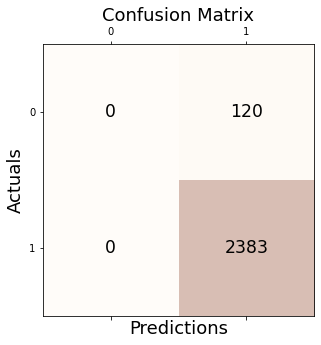

In [3010]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [3011]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_SO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_SO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_SO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_SO_GAAL_clf_one))

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975


### 9. MCD

In [3018]:
MCD_clf = MCD()
MCD_clf.fit(_df[['x', 'y','fnoise']])

MCD(assume_centered=False, contamination=0.1, random_state=None,
  store_precision=True, support_fraction=None)

In [3019]:
_df['MCD_clf'] = MCD_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

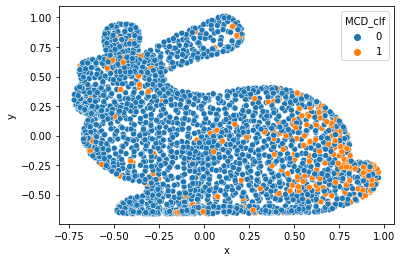

In [3020]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MCD_clf')

In [3021]:
outlier_MCD_one = list(MCD_clf.labels_)

In [3022]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [3023]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_MCD_one)

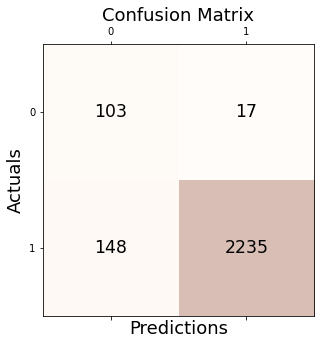

In [3024]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [3025]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_MCD_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_MCD_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_MCD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_MCD_one))

Accuracy: 0.934
Precision: 0.992
Recall: 0.938
F1 Score: 0.964


### 10. MO_GAAL

In [ ]:
MO_GAAL_clf = MO_GAAL()
MO_GAAL_clf.fit(_df[['x', 'y','fnoise']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

In [ ]:
_df['MO_GAAL_clf'] = MO_GAAL_clf.labels_

In [ ]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MO_GAAL_clf')

In [ ]:
outlier_MO_GAAL_clf_one = list(MO_GAAL_clf.labels_)

In [ ]:
outlier_MO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_clf_one))

In [ ]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_MO_GAAL_clf_one)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_MO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_MO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_MO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_MO_GAAL_clf_one))